# Práctica 4 : Entrenamiento de redes neuronales

Guillermo García Patiño Lenza y Mario Quiñones Pérez

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import scipy.optimize as opt

In [3]:
def cargaDatos(file = 'ex4data1.mat'):
    data = loadmat(file)
    y = data['y']
    X = data['X']
    return X,y

In [22]:
from displayData import displayData

def display_prueba(num):
    X, y = cargaDatos()
    ejs = np.random.choice(X.shape[0], num)
    (fig, ax) = displayData(X[ejs, :])

Eligiendo aleatoriamente 100 elementos del conjunto de datos y con ayuda de la función displayData proporcionada con la práctica se obtiene:

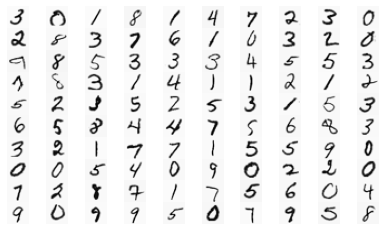

In [52]:
display_prueba(100)

## Función de coste


La red neuronal tiene la estructura formada por tres capas, con 400 unidades en la primera capa, 25 en la capa oculta y 10 en la capa de salida.

En la matriz de imágenes estas se han etiquetado de la siguiente manera: la imagen del 0 se ha etiquetado como “10”, manteniendo las etiquetas naturales del “1” al “9” para el resto de los números.

Por tanto usaremos un paso a one_hot para poder utilizar estos datos.

Onehot(5) = [0000100000]

In [6]:
def one_hot(y):
    m = len(y)
    
    y = (y-1)
    y_onehot = np.zeros((m, 10))
    
    for i in range(m):
        y_onehot[i][y[i]] = 1
        
    return y_onehot

In [7]:
(X,y) = cargaDatos('ex4data1.mat')

print(y)

y_oh = one_hot(y)
for i in np.random.randint(5000,size = 10):
    print("{} = {}".format(y_oh[i],y[i]))

[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] = [9]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] = [4]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] = [2]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] = [8]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] = [3]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] = [4]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] = [9]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] = [8]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] = [3]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] = [1]


In [8]:
def sigmoide(Z):
    sigmoide = 1 / (1 + np.exp(-Z))
    return sigmoide

In [9]:
def coste(theta1, theta2, X, Y, num_etiquetas): #Y preparada
    
    A1, A2, h = forward_prop(X, theta1, theta2)
    
    sum1 = Y*np.log(h)
    sum2 = (1-Y)*np.log(1 - h + 1e-6)
    
    return (-1 / X.shape[0]) * np.sum(sum1 + sum2)

In [10]:
def coste_reg(theta1, theta2, X, Y, num_etiquetas, Lambda):
    c = coste(theta1, theta2, X, Y, num_etiquetas)
    m = X.shape[0]
    
    e = sum(sum(theta1[:, 1:]**2)) + sum(sum(theta2[:, 1:]**2))
        
    return c + (Lambda/(2*m))*e

In [11]:
def forward_prop(X, theta1, theta2):
    n = X.shape[0]
    
    # Se añade una fila de unos a la matriz inicial 
    X = np.hstack([np.ones([n,1]), X])
    
    # La capa oculta utiliza la primera matriz de pesos para crear sus neuronas y le añade una fila de unos
    Oculta = sigmoide(np.dot(X, theta1.T))
    Oculta = np.hstack([np.ones([n,1]), Oculta])
    
    # El resultado se calcula pasando por la segunda matriz de pesos todas las neuronas de la capa oculta
    Resultado = sigmoide(np.dot(Oculta, theta2.T))
    
    return X, Oculta, Resultado

In [18]:
def prueba_coste(X, y, theta1, theta2):
    return coste(theta1, theta2, X, y, 10)

In [19]:
def prueba_coste_reg(X, y, theta1, theta2):
    return coste_reg(theta1, theta2, X, y, 10, 1)

Con los valores proporcionados para las matrices Θ(1) y Θ(2) comprobamos si el cálculo del coste es correcto tanto el regularizado como el normal.

In [20]:
datos = loadmat('ex4data1.mat')
cargas = loadmat('ex4weights.mat')

X = datos['X'] 
Y = datos['y']
theta1, theta2 =cargas['Theta1'], cargas['Theta2']

y = one_hot(Y)

print("Coste sin regularización = {}".format(prueba_coste(X, y, theta1, theta2)))
print("Coste sin regularización = {}".format(prueba_coste_reg(X, y, theta1, theta2)))

Coste sin regularización = 0.2876200116672695
Coste sin regularización = 0.38376070559687425


## Cálculo del gradiente


A continuación, implementaremos el cálculo del gradiente de una red neuronal de tres capas.

Se creará una función que recibe todos los parámetros de la red neuronal desplegados en un array unidimensional y que los devuelve de la misma forma. Esta devolverá una tupla (coste, gradiente).

Para el cálculo de este gradiente usaremos el algoritmo de retropropagación, que para cada ejemplo de entrenamiento $(x(t), y(t))$ se ejecuta primero una pasada “hacia delante” para así calcular la salida de la red $hθ(x)$. A continuación, se ejecuta una pasada “hacia atrás” para computar en cada nodo j de cada capa l su contribución $ δ(l)j $ al error que se haya producido en la salida.

Esta contribución se acumula en las matrices $∆(1)$ y $∆(2)$, inicializadas a 0, con las mismas dimensiones que $Θ(1)$ y $Θ(2)$ respectivamente.Una vez procesados los m ejemplos, el gradiente sin regularizar se obtiene dividiendo por m los valores acumulados en el bucle.

Tras calcular el gradiente se le añadirá el término de regularización $ lambda/m*Θ(l)ij $ a toda la matriz $ ∆(l) $ menos a la primera columna.

In [25]:
def gradiente(theta1, theta2, X, y):
    
    # Creamos los Delta con la forma de theta pero inicializados a cero
    Delta1 = np.zeros(np.shape(theta1))
    Delta2 = np.zeros(np.shape(theta2))
    
    m = len(y)
    
    #Se realiza la propagación hacia delante
    A1,A2,h = forward_prop(X, theta1, theta2)
    
    # Se realiza la propagación hacia atras para cada 
    # elemento para comprobar el fallo
    for k in range(m):
        a1k = A1[k, :]
        a2k = A2[k, :]
        a3k = h[k, :]
        yk = y[k, :]
        
        d3 = a3k - yk
        g_prima = (a2k * (1 - a2k))
        d2 = np.dot(theta2.T, d3) * g_prima
        
        
        Delta1 = Delta1 + np.dot(d2[1:, np.newaxis], a1k[np.newaxis, :])
        Delta2 = Delta2 + np.dot(d3[:, np.newaxis], a2k[np.newaxis, :])
    
    #Se devuelven los Deltas que corresponden al gradiente
    return Delta1/m , Delta2/m

In [26]:
def gradiente_reg(theta1, theta2, X, y, Lambda):
    m = len(y)
    Delta1, Delta2 = gradiente(theta1, theta2, X, y)
    
    #A cada elemento del gradiente (menos la primera columna) se le añade el termino de regularización Lambda
    # multiplicado por cada elemento de las matriz theta 1 y theta2
    Delta1[:,1:] = Delta1[:,1:] + (Lambda/m)*theta1[:,1:]
    Delta2[:,1:] = Delta2[:,1:] + (Lambda/m)*theta2[:,1:]
    
    return Delta1, Delta2

In [27]:
def backprop (params_rn ,num_entradas ,num_ocultas , num_etiquetas , X, y, reg):
    
# backprop devuelve una tupla (coste, gradiente) con el coste y el gradiente de
# una red neuronal de tres capas , con num_entradas , num_ocultas nodos en la capa
# oculta y num_etiquetas nodos en la capa de salida. Si m es el numero de ejemplos
# de entrenamiento, la dimensión de ’X’ es (m, num_entradas) y la de ’y’ es
# (m, num_etiquetas)

    theta1 = np.reshape(params_rn[:num_ocultas*(num_entradas + 1)],(num_ocultas,(num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas+1):],(num_etiquetas,(num_ocultas + 1)))

    m = len(y)
        
    D1, D2 = gradiente_reg(theta1, theta2, X, y, reg)
    
    coste = coste_reg(theta1, theta2, X, y, num_etiquetas, reg)
    
    gradiente = np.concatenate((np.ravel(D1), np.ravel(D2)))
    
    return coste , gradiente

In [43]:
datos = loadmat('ex4data1.mat')
X = datos['X'] 
Y = datos['y']

Y = one_hot(Y)

num_entradas = X.shape[1]
num_ocultas = 25
num_etiquetas = 10

INIT_EPSILON = 0.12

theta1 = np.random.random((num_ocultas,(num_entradas + 1)))*(2*INIT_EPSILON) - INIT_EPSILON
theta2 = np.random.random((num_etiquetas,(num_ocultas + 1)))*(2*INIT_EPSILON) - INIT_EPSILON

params_rn = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

backprop (params_rn ,num_entradas ,num_ocultas , num_etiquetas , X, Y, 0.1)

(6.765093517278932,
 array([-0.00825176,  0.        ,  0.        , ...,  0.17410425,
         0.21819694,  0.19763629]))

### Comprobación del gradiente

Para comprobar el cálculo del gradiente se utilizará la función incluida en la práctica checkNNGradients.

Dicha comprobación se realiza comparándolo con el resultado de un método aproximado que utiliza el cálculo del coste.

Supongamos que tenemos una función $fi(θ)$ que calcula el gradiente y queremos comprobar si el cálculo es correcto. Dados los vectores $θ(i+)$, que es igual que θ excepto porque al i-ésimo elemento se le ha sumado un valor pequeño epsilon, y $θ(i−)$, que se le ha restado ese mismo epsilon a la posición i ,podemos comprobar numéricamente el valor de $fi(θ)$ comprobando que para todo i se cumple que el coste de $θ(i+)$ menos el del coste de $ θ(i)$ partido dos epsilon es equivalente al gradiente.

Cuanto menor sea ese epsilon mayor será la similitud entre ambos valores.

Al ser este cálculo numérico muy costoso solo se hará la comprobación una vez y luego se utilizará el gradiente como tal.

In [53]:
from checkNNGradients import checkNNGradients

checkNNGradients ( backprop , 0.1 ) 

grad shape:  (38,)
num grad shape:  (38,)


array([ 2.86006259e-07, -1.44926309e-08,  5.17625875e-08,  7.04249071e-08,
       -3.26235469e-07,  5.95653303e-08, -1.21742581e-07, -1.91150149e-07,
       -5.32065243e-07,  1.04927864e-07, -2.56773482e-07, -3.82463637e-07,
       -3.06558803e-07,  3.85829526e-08, -1.04657968e-07, -1.51689812e-07,
        2.23858079e-07, -3.65876015e-08,  7.74611560e-08,  1.20305060e-07,
        8.74971631e-07,  4.50207454e-07,  4.00482634e-07,  4.47256173e-07,
        4.39713644e-07,  5.27031399e-07,  9.12219686e-07,  5.53073506e-07,
        3.42804977e-07,  4.81445995e-07,  5.05301518e-07,  4.87923142e-07,
        1.14645184e-06,  5.89118625e-07,  4.08370178e-07,  7.14643129e-07,
        4.95463758e-07,  5.42036173e-07])

## Aprendizaje de los parámetros

Ya comprobada la corrección del coste y el gradiente, podemos utilizar la función scipy.optimize.minimize para entrenar a la red neuronal y obtener los valores óptimos para theta.

Inicializaremos los pesos de la red con valores aleatorios pequeños en el rango [−0.12, 0.12].

In [28]:
def prueba_neurona(X, y, theta1, theta2):
    """función que devuelve el porcentaje de acierto de una red neuronal utilizando unas matrices de pesos dadas"""
    n = len(y)
    
    y = np.ravel(y)
    
    _ , _ , result = forward_prop(X, theta1, theta2)
    
    result = np.argmax(result, axis = 1)
    
    return (sum(result + 1 == y)/n*100)

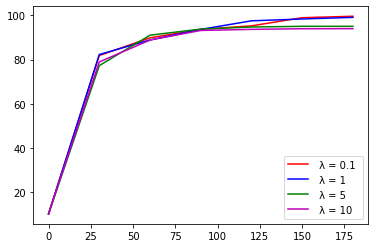

In [36]:
from scipy.optimize import minimize

datos = loadmat('ex4data1.mat')
X = datos['X'] 
y = datos['y']


y_onehot = one_hot(y)


input_size = X.shape[1]
hidden_size = 25
num_labels = 10
iteraciones = np.arange(0,200,30)
lambdas = [0.1, 1 , 5, 10]
colores = ['r', 'b' , 'g', 'm']

INIT_EPSILON = 0.12

theta1 = np.random.random((hidden_size,(input_size + 1)))*(2*INIT_EPSILON) - INIT_EPSILON
theta2 = np.random.random((num_labels,(hidden_size + 1)))*(2*INIT_EPSILON) - INIT_EPSILON

params = np.concatenate((np.ravel(theta1), np.ravel(theta2)))

plt.figure()

i = 0

for reg in lambdas:
    percent = []
    for iters in iteraciones:
        fmin = minimize(fun=backprop, x0=params,
                args=(input_size, hidden_size,
                num_labels, X, y_onehot, reg),
                method='TNC', jac=True,
                options={'maxiter': iters})

        theta1 = np.reshape(fmin.x[:hidden_size*(input_size + 1)],(hidden_size,(input_size + 1)))
        theta2 = np.reshape(fmin.x[hidden_size * (input_size+1):],(num_labels,(hidden_size + 1)))

        percent.append(prueba_neurona(X, y, theta1, theta2))
    plt.plot(iteraciones, percent, c = colores[i] , label = ' lambda = {} '.format(reg))
    i = i+1
    
plt.legend()
plt.savefig('acierto_reg_iter.png')
plt.show()

Tras el entrenamiento de la red podemos observar que cuanto mayor sea el número de iteraciones mejor será el entrenamiento de la red hasta más o menos las 75 iteraciones en las que parece estabilizarse. También vemos que cuanto mayor es lambda en este caso menor es el acierto en la red neuronal a partir de las 125 iteraciones aunque la diferencia no es significativa.